In [50]:
#import fastai.vision.all as fv
from fastai.vision.all import * 
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import random
from torchvision.transforms import ToTensor, ToPILImage
to_tensor = ToTensor()
to_pil = ToPILImage()
from math import prod

# Especificaciones de la práctica
 > Crear una red neuronal convolucional para clasificar.
 
 **Nota:** NO se vale usar modelos preentrenados.

**Restricciones:**
    
    > Máximo 5M de parámetros (sug: usa 'grupos' para reducir el número de parámetros)

    > Máximo entrenar 10 épocas
     
    > No modelos pre-entrenados!!

# Indice del notebook
- [Funciones de ayuda](#functions)
- [Carga de datos](#data)
- [Modelo](#model)
- [Entrenamiento](#training)
- [Otras pruebas](#other)

<a id="functions"><h1><strong>Algunas funciones de ayuda</strong></h1></a>

In [2]:
# Para tener idea de qué tan grande es nuestro modelo
def num_params(model):
    #total=0
    #for p in model.parameters():
        #num=1
        #for s in list(p.size()):
            #num *= s
        #total += num
        
    # Una manera de hacer más optimo lo anterior 
    total = sum([prod(p.shape) for p in model.parameters()])
    return (total)

In [3]:
# Función para cargar los datos
def load_data(folder, img_size, batch_size):
  # Dependiendo de los datos, elegimos las 
  # transformadas que le queremos hacer
  tfms = fv.aug_transforms(flip_vert=False, 
                           max_rotate=10, 
                           max_lighting=0.3,
                           max_zoom=1.2, 
                           max_warp=0.1)
   
  h,w = [int(2*t) for t in img_size]
  data = fv.DataBlock(blocks = (fv.ImageBlock, fv.CategoryBlock),
                      get_items=fv.get_image_files,
                      get_y=fv.parent_label,
                      splitter=fv.GrandparentSplitter(), 
                      #item_tfms=fv.Resize(img_size),
                      item_tfms = fv.Resize((h,w)),
                      batch_tfms=tfms,
                      )
  return data.dataloaders(folder, bs=batch_size)



Creamos una función para conectar las convoluciones con las líneas densas

Es decir pasar de la parte convolucional a la parte completamente conectada


In [4]:
# Esta capa servirá para conectar las convolucionales con las lineas densas
class Flatten(nn.Module): #Para hacer un modulo de pytorch, tienes que heredar
    # de nn.Module
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        # return (x.squeeze()) Esto funciona solo si la batchsize es >1
        # si es 1, esto se lo va a quitar
        # solución 
        return (x.view(x.shape[0], -1)) 
        #x.shape[0] es la batchsize
        #-1 si se lo pasas a reshape o a view les dice algo 
        # como tú adivina de que tamaño debe de ser esto

In [5]:
def my_own_splitter(m):
    # la última parte esta en su propio grupo
    # Es decir, la parte linear que se encargara de nuestras salidas
    # estara en su propio grupo
    # Partimos en cinco capas el modelo 
    # siendo la última la capa linear
    return [list(group.parameters()) for group in [m[0:5], m[5:10],m[10:15],m[15:21],m[21:]]]

<a id="data"><h1><strong>Cargar los datos</strong></h1></a>

In [6]:
!ls "/storage/images"

train  valid


In [7]:
data = Path('/storage/images')

In [8]:
data

Path('/storage/images')

In [9]:
#data = load_data(data, img_size=224, batch_size=54)

In [10]:
data_to_work = load_data(data, (128,192), 54) # Debo de experimentar con multiples tamaños

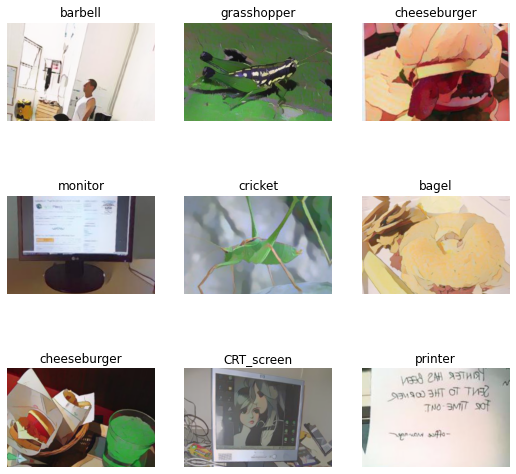

In [11]:
data_to_work.show_batch()

<a id="model"><h1><strong>Creación del modelo</strong></h1></a>

In [57]:
# Primer creación: red neuronal convolucional 
my_aux_model = nn.Sequential(
    # Normalizamos los datos
    nn.BatchNorm2d(3),
    # Convolución
    # padding le pone un borde negro a la imagen para no tener perdida de pixeles
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
    # Activación 
    nn.LeakyReLU(),
    nn.BatchNorm2d(32),
    # Maxpool2d toma cada cuadrito de 2x2 y de esos 4 toma 
    # el mayor, reduciendo así todo a la mitad
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2), 
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.BatchNorm2d(512),
    # Aquí es donde pasamos a la parte líneal
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(512, 256), 
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, data_to_work.c))

<a id="training"><h1><strong>Entrenamiento del modelo</strong></h1></a>

In [58]:
print(f"Num parameters: {num_params(my_aux_model)/10**6:.2f}M")

Num parameters: 1.71M


In [59]:
# Intenta usar Mixup o Cutmix! Intenta ranger!
learner = fv.Learner(data_to_work, my_aux_model, opt_func=fv.ranger, metrics=fv.accuracy, splitter=my_own_splitter).to_fp16()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0030199517495930195)

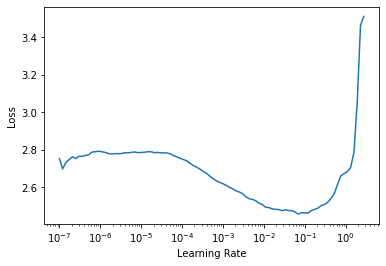

In [60]:
learner.lr_find()

In [61]:
learner.fit_one_cycle(10, lr_max=slice(1e-3, 2e-4), div=0.9, div_final=10000, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,1.725455,1.657498,0.432857,00:38
1,1.561166,1.506040,0.455714,00:38
2,1.404471,1.413405,0.478571,00:38
3,1.287668,1.524100,0.460000,00:38
4,1.217893,1.484783,0.448571,00:38
5,1.113000,1.325526,0.492857,00:38
6,1.107340,1.309867,0.504286,00:38
7,1.046275,1.135053,0.572857,00:38
8,0.948833,1.123250,0.594286,00:38
9,0.841782,1.081773,0.602857,00:38


<a id="other"><h1><strong>A partir de aquí son otros modelos que probe con otras cosas pero no sirvieron
</strong></h1></a>

> No es necesario que los revise, el anterior es el bueno

In [62]:
# Primer creación: red neuronal convolucional 
my_aux_model2 = nn.Sequential(
    # Normalizamos los datos
    nn.BatchNorm2d(3),
    # Convolución
    # padding le pone un borde negro a la imagen para no tener perdida de pixeles
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
    # Activación 
    nn.LeakyReLU(),
    nn.BatchNorm2d(32),
    # Maxpool2d toma cada cuadrito de 2x2 y de esos 4 toma 
    # el mayor, reduciendo así todo a la mitad
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2), 
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.BatchNorm2d(512),
    # Aquí es donde pasamos a la parte líneal
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(512, 256), 
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, data_to_work.c))

In [63]:
learner2_mauxmodel = fv.Learner(data_to_work, my_aux_model2, opt_func=fv.ranger, metrics=fv.accuracy, splitter=my_own_splitter).to_fp16()

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0004786300996784121)

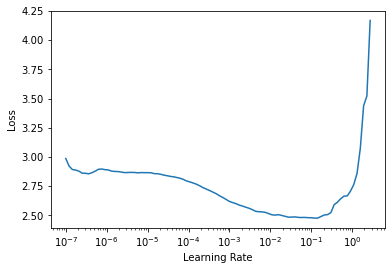

In [64]:
learner2_mauxmodel.lr_find()

In [70]:
learner2_mauxmodel.fit_one_cycle(10, cbs=MixUp(1.), lr_max=slice(1e-3, 2e-4), div=0.9, div_final=10000, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,2.176064,1.750947,0.378571,00:39
1,2.050684,1.627664,0.418571,00:39
2,1.961368,1.552336,0.445714,00:38
3,1.936958,1.471271,0.448571,00:38
4,1.865077,1.638076,0.387143,00:39
5,1.823432,1.562234,0.448571,00:39
6,1.801544,1.430118,0.500000,00:39
7,1.754088,1.335897,0.525714,00:38
8,1.711111,1.246278,0.550000,00:38
9,1.656862,1.200026,0.568571,00:39


In [71]:
from fastai.vision.all import delegates

In [72]:
def conv2d(ni,no,k=3,s=1,pad="same",g=1,bias=True):
    """ni, no son num de canales de entrada y salida respectivamente"""
    if pad=="same": pad = (k-1)//2

    return nn.Conv2d(ni,no,kernel_size=k,stride=s,padding=pad,groups=g,bias=bias)

In [73]:

@delegates(conv2d)
def cab(ni, no, act_fn=nn.ReLU(), **kwargs):
    """cab se refiere a convolucion->activacion->batchnorm :)"""
    layers = []
    
    layers += [conv2d(ni, no, **kwargs)]
    layers += [act_fn]
    layers += [nn.BatchNorm2d(no)]
    
    return layers

In [74]:
class ResBlock(nn.Module):
    def __init__(self, ni, no = None, stride=1):
        super().__init__()
        self.stride = stride
        if no is None: no = ni
            
        k = 3
        if stride == 2:
            k = 4
            
        use_pool = (ni != no) or (stride != 1)
        
        self.pool = nn.Sequential(*cab(ni,no,k=k,s=stride))
        self.residual = nn.Sequential(*cab(ni,ni//2,k=k,s=stride), # juega con esto!!
                                      *cab(ni//2,no//2), 
                                      *cab(no//2, no)
                                     )
        nn.init.zeros_(self.residual[-1].weight) # juega con esto!!
        
    def forward(self, x):
        return self.pool(x) + self.residual(x)

In [75]:
other_model = nn.Sequential(
    # Normalizamos los datos
    nn.BatchNorm2d(3),
    # Convolución
    # padding le pone un borde negro a la imagen para no tener perdida de pixeles
    nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1),
    # Activación 
    nn.LeakyReLU(),
    nn.BatchNorm2d(16),
    # Maxpool2d toma cada cuadrito de 2x2 y de esos 4 toma 
    # el mayor, reduciendo así todo a la mitad
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2), 
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    ResBlock(128),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    ResBlock(256),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.BatchNorm2d(512),
    # Aquí es donde pasamos a la parte líneal
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(512, 256), 
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, data_to_work.c))

In [76]:
learner2 = fv.Learner(data_to_work, other_model, opt_func=fv.ranger, metrics=fv.accuracy, splitter=my_own_splitter).to_fp16()

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.0014454397605732083)

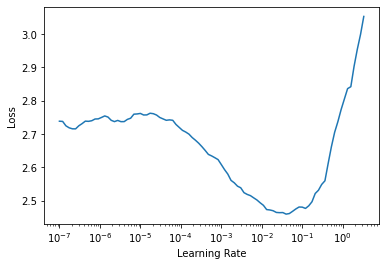

In [77]:
learner2.lr_find()

In [78]:
learner2.fit_one_cycle(10, lr_max=slice(1e-3, 2e-4), div=0.9, div_final=10000, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,1.759014,1.618870,0.417143,00:40
1,1.493197,1.461440,0.480000,00:40
2,1.361515,1.363041,0.484286,00:39
3,1.286120,1.281063,0.528571,00:40
4,1.211849,1.258380,0.535714,00:40
5,1.152579,1.192232,0.531429,00:39
6,1.084775,1.180015,0.552857,00:40
7,1.063269,1.208440,0.540000,00:40
8,0.952826,1.103684,0.571429,00:39
9,0.841630,1.073614,0.577143,00:40
